In [ ]:
import os
import getpass

from langchain_groq import ChatGroq



# Building Blocks: The Augmented LLM

In [2]:
llm = ChatGroq( # model="mixtral-8x7b-32768",
    model="gemma2-9b-it",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [4]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search")
    justification: str = Field(None, description ="why this query is relevant to the user's request")


# llm에 구조화된 출력을 위한 스키마 추가
structured_llm = llm.with_structured_output(SearchQuery)

# invoke
output = structured_llm.invoke("칼슘 CT 점수는 높은 콜레스테롤과 어떤 관련이 있나요?")
print(output) 

# 툴만들기
def multiply(a: int, b: int) -> int:
    return a * b

# 툴 바인드
llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("2곱하기 3은 뭐지?")

search_query='calcium CT score and high cholesterol' justification='The user is asking about the relationship between calcium CT score and high cholesterol.'


In [5]:
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_a6g9',
  'type': 'tool_call'}]

In [6]:
msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a6g9', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 963, 'total_tokens': 1050, 'completion_time': 0.158181818, 'prompt_time': 0.080447898, 'queue_time': 0.39791199099999996, 'total_time': 0.238629716}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c58290b-fce0-454b-9e7b-001a0ee1b997-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_a6g9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 963, 'output_tokens': 87, 'total_tokens': 1050})

## 프롬프트 체이닝
- 각 LLM 호출이 이전 호출의 출력을 처리하여 이어지는 방식
- 하나의 작업을 여러 단계(sequence of steps)로 분해하는 방법
    - 각 LLM 호출이 이전 호출의 출력을 받아 처리하는 구조
    - 중간 단계(intermediate steps)에 게이트 가틍ㄴ 프로그래밍적 검증을 추가할 수 있음
        - 이를 통해 프로세스가 올바르게 진해오디고 있는지 확인 가능

### 언제 사용?
- 작업이 명확하게 고정된 하위 작업으로 분해될 수 있는 경우
- 더 높은 정확도를 위해 실행 속도를 희생할 수 있는 경우
- 각 LLM 호출이 더 작은 단위의 쉬운 작업을 수행하도록 만들고 싶은 ㄱ경우

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [8]:
# Graph State
class State(TypedDict):
    topic :  str
    joke : str
    improved_joke : str
    final_joke : str

# Node
def generate_joke(state: State) -> State:
    # 초기 조크 생성을 위한 첫 번쨰 llm 호출
    msg = llm.invoke(f"{state['topic']}에 관련된 짧은 조크를 작성해라")
    return {"joke": msg.content}

def check_punchline(state: State) -> State:
    # 조크의 펀치라인이 적절한지 확인하기 위한 Gate 함수

    # 간단한 체크 - 조크가 ? 또는 !를 포함하는지 확인
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State) -> State:
    # 조크를 개선하기 위한 두 번째 llm 호출
    msg = llm.invoke(f"말 장난을 추가하여 이 조크를 더 재밌게 만들어라 : {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"이 농담에 놀라운 반전을 추가해라라: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [10]:
# 워크플로우 빌드

workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# 엣지 추가
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END})

workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# 컴파일 
chain = workflow.compile()

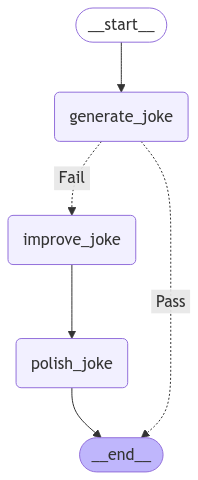

In [11]:
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [12]:
# invoke
state = chain.invoke({"topic" : "고양이"})

print("Initial joke:", state["joke"])
print(state["joke"])
print("\n=====================================\n")

# 향상됐는지 확인
if "improve_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n=====================================\n")

    # 최종 조크
    print("Final joke:")
    print(state["final_joke"])
else:
    print("펀치라인이 감지되지 않았습니다. 조크를 개선할 수 없습니다.")



Initial joke: 왜 고양이가 항상 땅을 긁나요? 

> 답: 그들은 땅에 숨겨진 쥐를 찾고 있어요! 😹 


더 짧은 조크가 필요하시면 말씀해주세요! 

왜 고양이가 항상 땅을 긁나요? 

> 답: 그들은 땅에 숨겨진 쥐를 찾고 있어요! 😹 


더 짧은 조크가 필요하시면 말씀해주세요! 



펀치라인이 감지되지 않았습니다. 조크를 개선할 수 없습니다.


## 병렬처리

### 병렬 처리 방식 2 가지
1. 섹셔닝(Sectioning)
- 하나의 작업을 독립적인 하위 작업으로 나누어, 병렬로 실행하는 방식

2. 투표(Voting)
- 동일한 작업을 여러번 실행하여 다양한 출력을 생성한 후,
- 결과를 비교하여 더 신뢰할 수 있는 답변을 선택하는 방식 


### 언제 병렬처리?
1. 분할된 하위 작업이 병렬로 실행될 수 있어, 속도를 향상할 수 있는 경우
2. 더 신뢰할 수 있는 결과를 얻기 위해, 여러 번 시도하거나 다양한 관점을 반영해야하는 경우
3. 복잡한 작업에서 다양한 고려요소가 필요한 경우

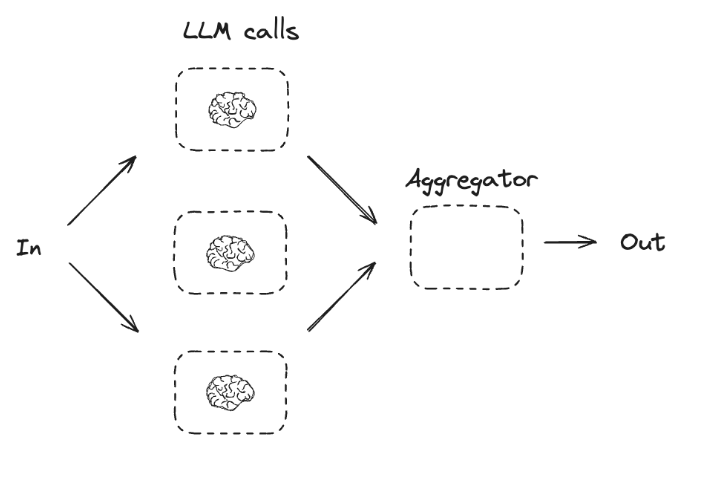

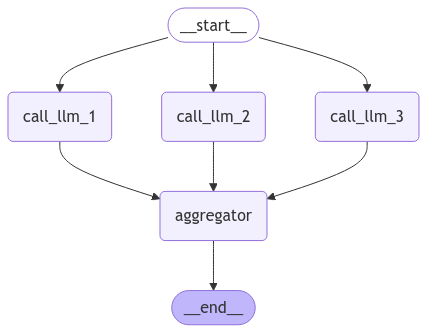

In [15]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# 노드 
def call_llm_1(state: State):
    # 초기 조크 생성을 위한 첫 번쨰 llm 호출  
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke" : msg.content}

def call_llm_2(state: State):
    # 이야기 생성을 위한 두 번째 llm 호출
    msg = llm.invoke(f"Write a short story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    # 시 생성을 위한 세 번째 llm 호출
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    "조크와 이야기를 하나의 출력으로 결합"

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}



# 워크플로우 빌드
paralled_builder = StateGraph(State)

# 노드 추가
paralled_builder.add_node("call_llm_1", call_llm_1)
paralled_builder.add_node("call_llm_2", call_llm_2)
paralled_builder.add_node("call_llm_3", call_llm_3)
paralled_builder.add_node("aggregator", aggregator)

# 엣지 추가
paralled_builder.add_edge(START, "call_llm_1")
paralled_builder.add_edge(START, "call_llm_2")
paralled_builder.add_edge(START, "call_llm_3")
paralled_builder.add_edge("call_llm_1", "aggregator")
paralled_builder.add_edge("call_llm_2", "aggregator")
paralled_builder.add_edge("call_llm_3", "aggregator")

paralled_builder.add_edge("aggregator", END)

paralled_workflow = paralled_builder.compile()


# Show workflow
display(Image(paralled_workflow.get_graph().draw_mermaid_png()))

In [16]:
# invoke
state = paralled_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Jasper, a ginger tabby with a crooked tail, surveyed his domain from atop the highest bookshelf. Below him, chaos reigned. Mittens, a fluffy white cat with eyes like sapphires, was batting at a feather toy, her tail whipping back and forth like a metronome gone mad. Luna, a sleek black cat with a mischievous glint in her eyes, stalked a sunbeam that danced across the living room floor.

Jasper sighed. This was the daily routine. Play, nap, chase the red dot, repeat. It was predictable, comfortable, and utterly boring. He craved adventure, excitement, something beyond the confines of their human's apartment.

One afternoon, a strange scent drifted in through the open window. It was a mix of earth and something wild, something that sent shivers down Jasper's spine. He nudged Luna, who was curled up in a sunbeam, her purring a gentle rumble.

"Luna, do you smell that?" he whispered, his whiskers twitching.

Luna opened one emerald eye, sn

### 랭스미스 확인
1. call_llm_1
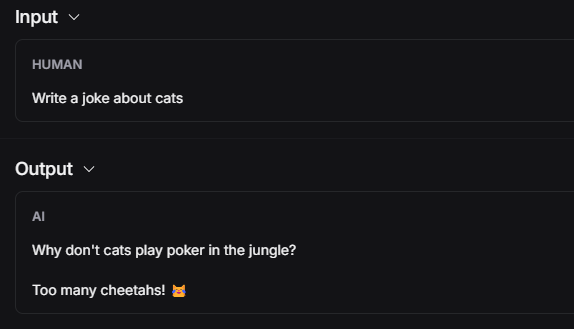

2. call_llm_2 
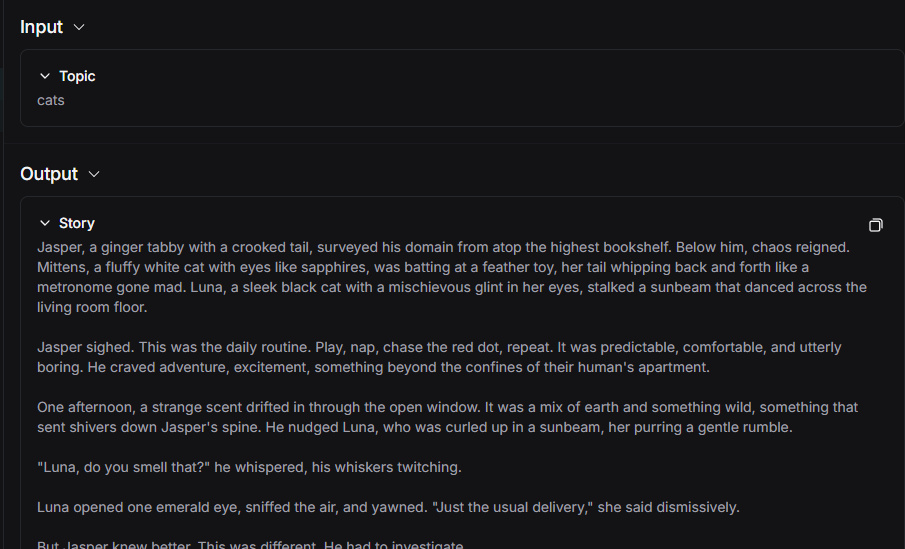

3. call_llm_3
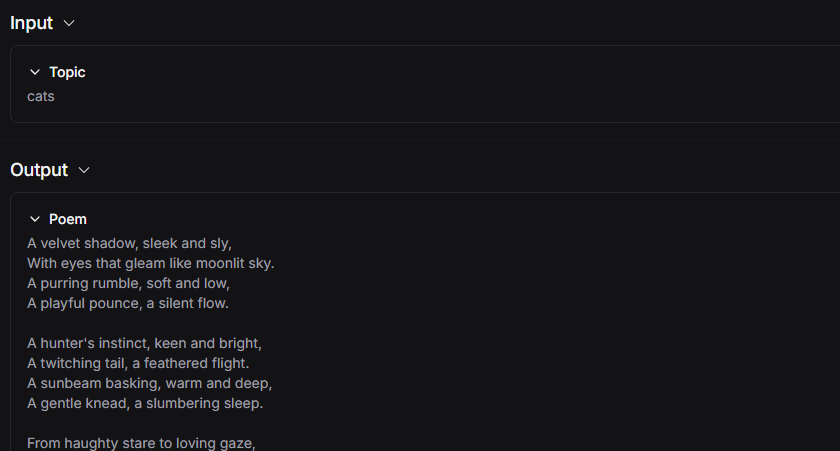


4. aggregator
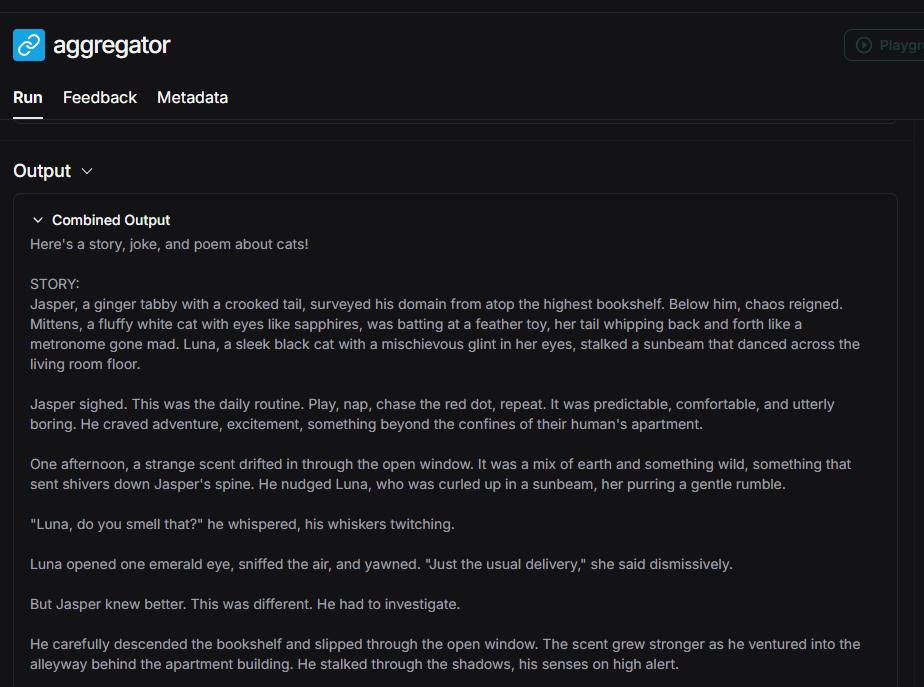


# 라우팅(Routing) 
- 입력을 분류하고, 적절한 후속작업(follow-up task)으로 연결하는 방식


## 언제 사용?
1. 복잡한 작업에서 입력이 여러 개의 뚜렷한 범주(카테고리)로 나뉘는 경우
2. 각 범주를 개별적으로 처리하는 것이 더 효과적인 경우
3. 입력 데이터를 정확하게 분류할 수 있는 방법이 있는 경우

    - LLM 이용한 분류
    - 기존 머신러닝 분류 모델
    - 전통적인 알고리즘

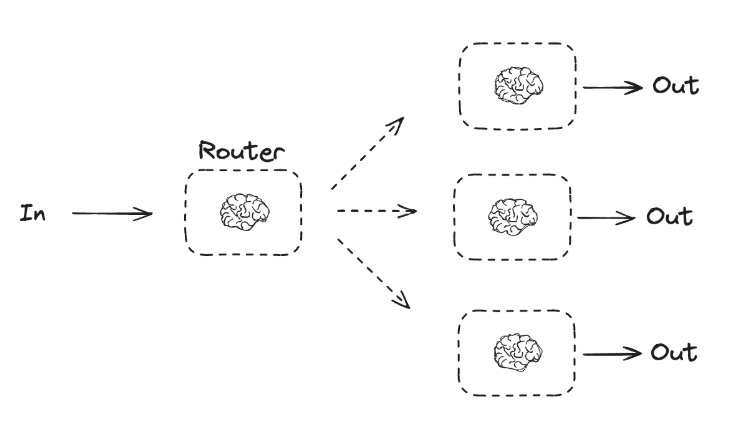